In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from scipy.stats import skew

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ContrastBiasStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

from myutils import *

In [2]:
# Get Xtalk Streak BOT images

In [3]:
repo = '/sdf/group/rubin/repo/main/butler.yaml'
collections = ['LSSTCam/raw/all']
butler_raw = daf_butler.Butler(repo, collections=collections)

run = '13241'
where = "exposure.science_program='%s' and exposure.observation_type='spot' " % (run)
detnum = 166  # R41_S11 
dsrefs = list(set(butler_raw.registry.queryDatasets('raw', where=where,detector=detnum).expanded()))

In [4]:
print(len(dsrefs))

400


# Get Summary info from all Images in this Run

In [5]:
df = get_run_info('13241',butler_raw,detector=166)

In [7]:
df = df.sort_values('mjd_begin',ignore_index=True)

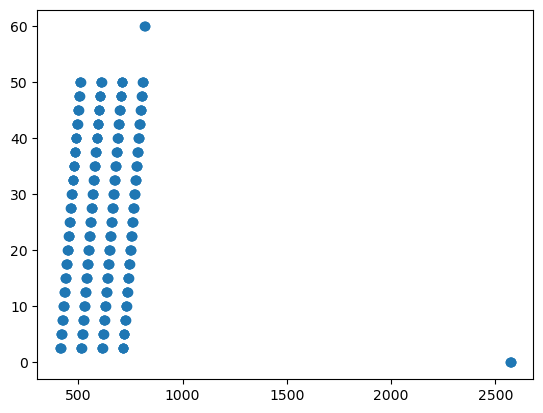

In [9]:
f,ax = plt.subplots(1,1)
h = ax.scatter(df.seq_num,df.exposure_time)

# Get one of the 10 second exposures... there should be 20 of them - 5 each in 4 positions...

In [10]:
run = '13241'
where = "exposure.science_program='%s' and exposure.observation_type='spot' and exposure.exposure_time=10.0 " % (run)
detnum = 166  # R41_S11 
dsrefs_10 = list(set(butler_raw.registry.queryDatasets('raw', where=where,detector=detnum).expanded()))

In [11]:
for i,aref in enumerate(dsrefs_10):
    print(i,aref.dataId.records['exposure'].seq_num,aref.dataId.records['exposure'].obs_id)

0 427 MC_C_20211226_000427
1 727 MC_C_20211226_000727
2 527 MC_C_20211226_000527
3 729 MC_C_20211226_000729
4 631 MC_C_20211226_000631
5 428 MC_C_20211226_000428
6 431 MC_C_20211226_000431
7 629 MC_C_20211226_000629
8 628 MC_C_20211226_000628
9 429 MC_C_20211226_000429
10 529 MC_C_20211226_000529
11 430 MC_C_20211226_000430
12 530 MC_C_20211226_000530
13 531 MC_C_20211226_000531
14 728 MC_C_20211226_000728
15 528 MC_C_20211226_000528
16 731 MC_C_20211226_000731
17 630 MC_C_20211226_000630
18 627 MC_C_20211226_000627
19 730 MC_C_20211226_000730


## seq_num=727 is here: https://lsst-camera-dev.slac.stanford.edu/FITSInfo/view.html?image=MC_C_20211226_000727&raft=R41&color=grey&bias=Simple+Overscan+Correction&scale=Per-Segment

# view the raw Image...

In [24]:
# get the Image
raw0 = butler_raw.get(dsrefs_10[1])

In [25]:
segments = ['C%02d' % (i) for i in list(range(7+1)) + list(range(10,17+1))]
print(segments)

['C00', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17']


In [26]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()

In [27]:
def get_regions(raw0):
   
    imaging = {}
    serial = {}
    parallel = {}
    det = raw0.getDetector()
    
    ccdid = det.getId()
    camdet = camera[ccdid]
    
    for seg in segments:
        
        # for raw images, get the imaging section and the serial/parallel overscan regions        
        amp = det[seg]
        rawamp = camdet[seg]
        
        serial_arr = raw0[amp.getRawSerialOverscanBBox()].getImage().array
        parallel_arr = raw0[amp.getRawParallelOverscanBBox()].getImage().array
        imaging_arr = raw0[amp.getRawDataBBox()].getImage().array

        # if need to flip X or Y, do it
        if rawamp.getRawFlipX():
            serial_arr = np.fliplr(serial_arr)
            parallel_arr = np.fliplr(parallel_arr)
            imaging_arr = np.fliplr(imaging_arr)
        if rawamp.getRawFlipY():
            serial_arr = np.flipud(serial_arr)
            parallel_arr = np.flipud(parallel_arr)
            imaging_arr = np.flipud(imaging_arr)

        imaging[seg] = imaging_arr
        serial[seg] = serial_arr
        parallel[seg] = parallel_arr
        
    return imaging,serial,parallel

In [28]:
amp = raw0.getDetector()['C10']
print(amp.getRawBBox())
print(amp.getRawSerialPrescanBBox())
print(amp.getRawSerialOverscanBBox())
print(amp.getRawParallelOverscanBBox())
print(amp.getRawDataBBox())

# Corners don't seem to be available with their own BBox

(minimum=(0, 2048), maximum=(575, 4095))
(minimum=(573, 2096), maximum=(575, 4095))
(minimum=(0, 2096), maximum=(63, 4095))
(minimum=(64, 2048), maximum=(572, 2095))
(minimum=(64, 2096), maximum=(572, 4095))


In [29]:
imaging,serial,parallel = get_regions(raw0)

Text(0.5, 0, 'Pixel Value [ADU]')

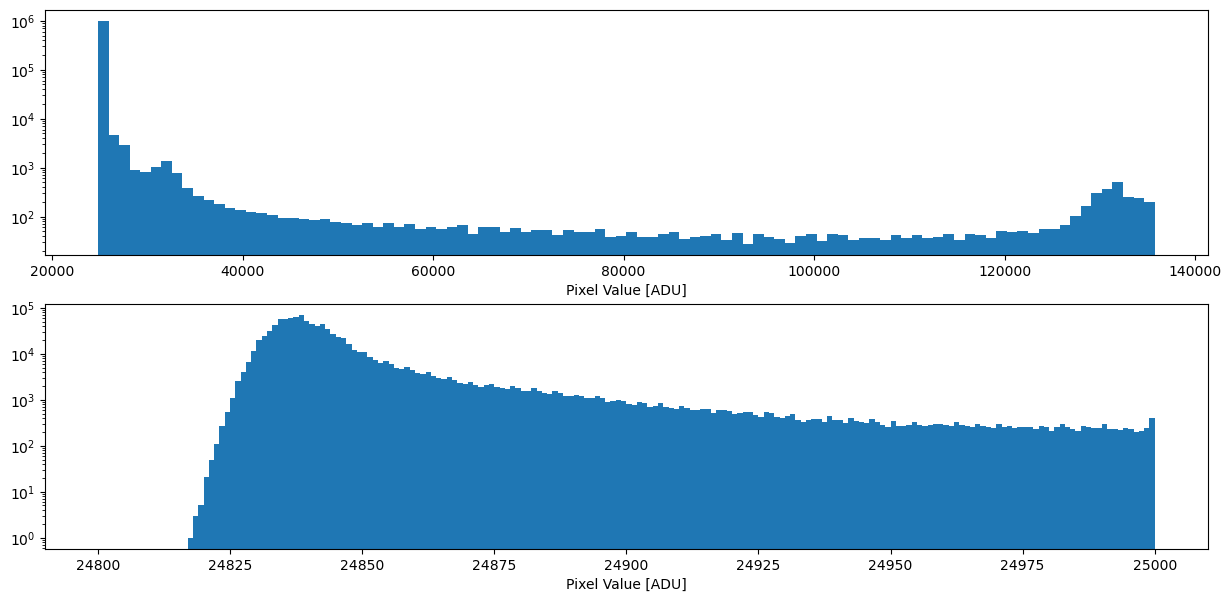

In [30]:
f,ax = plt.subplots(2,1,figsize=(15,7))
h = ax[0].hist(imaging['C00'].flatten(),bins=100)
ax[0].set_yscale('log')
ax[0].set_xlabel('Pixel Value [ADU]')

h = ax[1].hist(imaging['C00'].flatten(),bins=200,range=(24800.,25000.))
ax[1].set_yscale('log')
ax[1].set_xlabel('Pixel Value [ADU]')

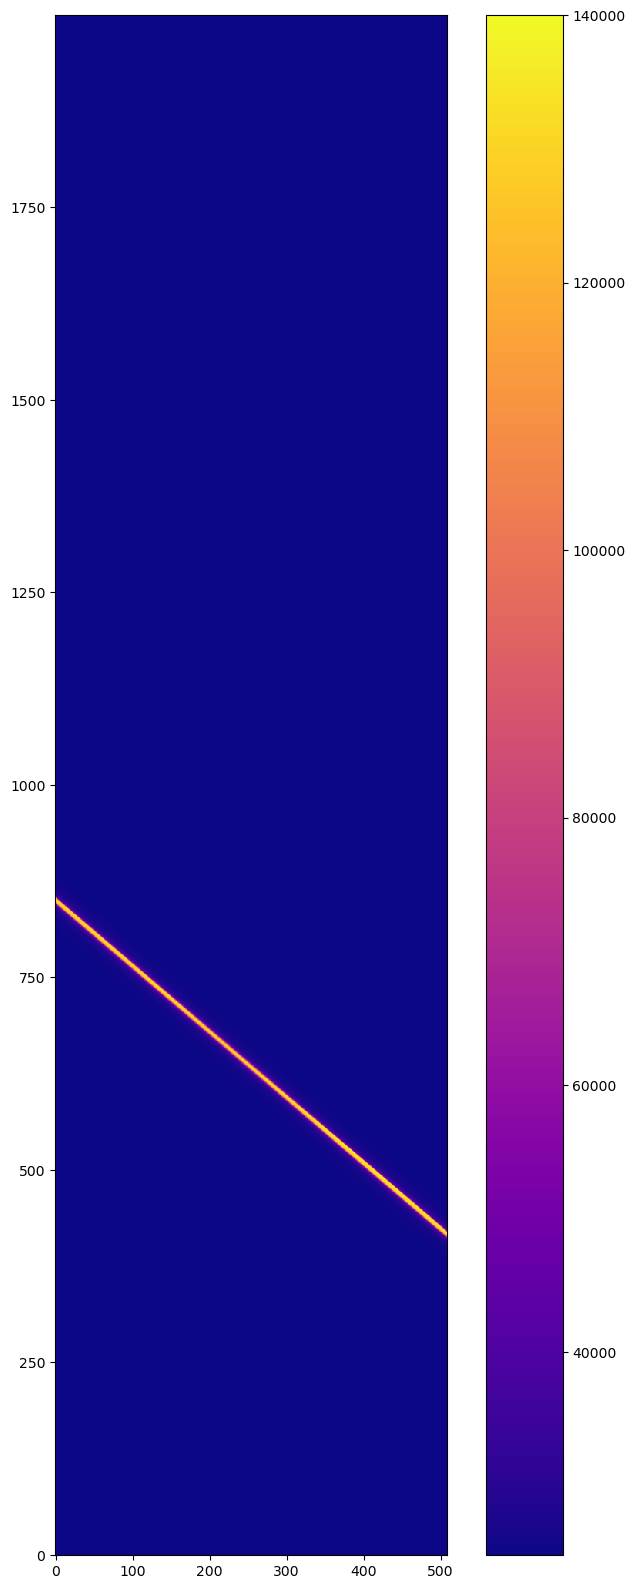

In [31]:
f,ax = plt.subplots(1,1,figsize=(20,20))

im, norm = imshow_norm(imaging['C00'], ax, origin='lower', interpolation='None',cmap='plasma',
                       interval=ManualInterval(24820.,140000.),
                       stretch=LinearStretch())
add_colorbar(im)

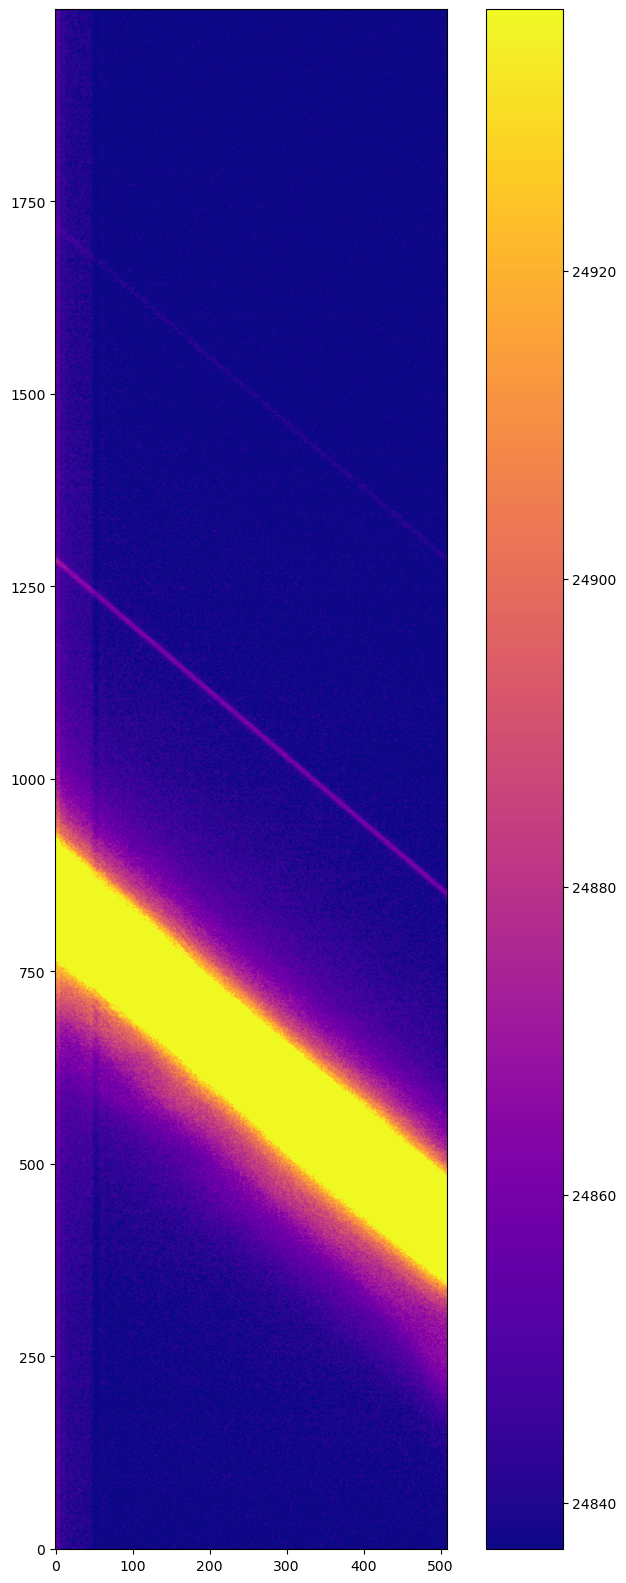

In [32]:
f,ax = plt.subplots(1,1,figsize=(20,20))

im, norm = imshow_norm(imaging['C00'], ax, origin='lower', interpolation='Gaussian',cmap='plasma',
                       interval=ZScaleInterval(),
                       stretch=LinearStretch())
add_colorbar(im)